<a href="https://colab.research.google.com/github/2series/Rockwall_Capital/blob/main/YouTrack_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://media.giphy.com/media/3o7bufkPz3LRof205G/giphy.gif)

# Fault Analysis

**Fault Analysis** to get insights into how buggy your system might be. One variant of *Fault Analysis* is to use an issue tracker (i.e., the system where you manage your issues) to compare the found and fixed bugs over time. With this analysis, you can find out if you

+ have a spike in reported bugs (where you should investigate deeper to identify the primary sources of the bugs)
+ are doing well fixing bugs (and therefore can be confident to release a stable version of your software)
+ are keeping bugs at bay (to allow the implementation of new features in a more risk-free environment)

The main goal of this post is to implement this kind of analysis

In this blog / notebook, we'll demonstrate a *Fault Analysis* technique using the issues tracker system [YouTrack](https://www.jetbrains.com/youtrack/) and the Data Science framework [pandas](https://pandas.pydata.org/) – Pandas is a popular Python library used for working in tabular data (similar to the data stored in a spreadsheet). It provides helper functions to read data from various file formats like CSV, Excel spreadsheets, HTML tables, JSON, SQL, and more. We want to analyze the relatively new software product [Code With Me](https://plugins.jetbrains.com/plugin/14896-code-with-me) from Jetbrains (a plugin that enables us to share our locally running project from our IDE with anyone). The issues from Code With Me are managed in YouTrack, hosted by Jetbrains, and open to everyone. This allows us to use this issues tracker as our playground

The second goal is to write as less confusing analysis code as possible. We want to achieve this by using pure pandas functionality to get a readable analysis of the defects in a software application. This said, be aware that your issue tracker might bring *Defect Analysis* to you out of the box (YouTrack does this AFAIK). Click through the reporting features of your system before you reinvent the wheel! Nevertheless, we'll show you how you can do it on your own. There might be similar use cases to track the progress of work. In these cases, you can reuse many steps from this analysis

*Please note: I'm not affiliated with Jetbrains. Jetbrains simply has on open issue management system where we can get some data from in an easy way. You can do this kind of analysis with any modern issues tracker system as well*

## Import pandas library

In [1]:
import pandas as pd

## Retrieve the data

First, we have to retrieve the data we need from the issue tracker system. We can do this in various ways (direct database access, scraping the website, or using an API provided by the system). How this works depends on your tool

In our case, we're using [YouTrack's REST API](https://www.jetbrains.com/help/youtrack/devportal/youtrack-rest-api.html) to download some data. To do this, we create an URL to get the data we need. We've dug deep into the YouTrack REST API documentation and found the information we needed to export bugs only with their creation and resolved timestamps. We also set an upper limit to the latest 1100 entries to not overload the available public issue tracker system

In [2]:
URL = "https://youtrack.jetbrains.com/api/issues?" \
"$top=1100&"\
"fields=created,resolved&"\
"query=Type:%20Bug%20Project%3A%20%7BCode%20With%20Me%7D"

URL

'https://youtrack.jetbrains.com/api/issues?$top=1100&fields=created,resolved&query=Type:%20Bug%20Project%3A%20%7BCode%20With%20Me%7D'

In our analysis, we're using the built-in read_json method of pandas. The method executes a request to YouTrack. Youtrack responds with data in the JSON format. The read_json method parses this data and creates a DataFrame where each returned field is showcased into separate columns

In [3]:
youtrack_df = pd.read_json(URL)
youtrack_df

,resolved,created,$type
0,NaN,1625762882126,Issue
1,NaN,1625763250122,Issue
2,NaN,1607484484129,Issue
3,1.625758e+12,1624959097262,Issue
4,1.625758e+12,1600857961089,Issue
...,...,...,...
1095,1.606974e+12,1602318321660,Issue
1096,1.606974e+12,1602256253762,Issue
1097,1.612120e+12,1602237475079,Issue
1098,1.612120e+12,1601989720737,Issue


Here's what we can tell by looking at the DataFrame:

+ The file provides three column-wise counts for  issues tracker system YouTrack
+ The metrics reported are created, resolved, and type
+ Data is provided for 1100 issues: from Apr 17, 2020, to July 8, 2021

Data from the file is read and stored in a DataFrame object – one of the core data structures in Pandas for storing and working with tabular data. We typically use the _df suffix in the variable names for DataFrames

In [4]:
type(youtrack_df)

pandas.core.frame.DataFrame

We can view some basic information about the DataFrame using the `.info` method

In [5]:
youtrack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   resolved  693 non-null    float64
 1   created   1100 non-null   int64  
 2   $type     1100 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 25.9+ KB


It appears that each column contains values of a specific data type. We can view statistical information for numerical columns (mean, standard deviation, minimum/maximum values, and the number of non-empty values) using the `.describe` method

In [6]:
youtrack_df.describe()

,resolved,created
count,6.930000e+02,1.100000e+03
mean,1.614854e+12,1.613047e+12
std,5.959582e+09,7.637254e+09
min,1.602102e+12,1.587082e+12
25%,1.609806e+12,1.606954e+12
50%,1.615283e+12,1.614275e+12
75%,1.618830e+12,1.618277e+12
max,1.625759e+12,1.625763e+12


Missing values for every column

In [7]:
youtrack_df.isna().sum()

resolved    407
created       0
$type         0
dtype: int64

With our DataFrame (stored in the variable youtrack_df), we can dig into the analysis of the development of opened (the column created: the time a bug was created) and closed (the column resolved: the time where a bugfix was confirmed) bugs. First, we remove the $type column because we don't need the information for our analysis

In [8]:
faults_df_copy = youtrack_df[['resolved', 'created']].copy()
faults_df_copy

,resolved,created
0,NaN,1625762882126
1,NaN,1625763250122
2,NaN,1607484484129
3,1.625758e+12,1624959097262
4,1.625758e+12,1600857961089
...,...,...
1095,1.606974e+12,1602318321660
1096,1.606974e+12,1602256253762
1097,1.612120e+12,1602237475079
1098,1.612120e+12,1601989720737


The data within `faults_df_copy` is completely separate from youtrack_df

## Exploratory data analysis

Cool, let's take a look at the development of the reported and fixed bugs. One important question we would like to answer is whether we are getting behind with bug fixing. For this, we are calculating the creation and resolution of bugs over time. That means for us that we have first to convert the corresponding data in the columns created and resolved into a **data format** we can calculate time with. For this, we're using the `to_datetime` method for converting the text in these columns into the Timestamp data type. Because the retrieved data has a timestamp information in milliseconds since epoch (01/01/1970 00:00:00) we have to provide this information as additional parameter unit

In [9]:
faults_df_copy['created'] = pd.to_datetime(faults_df_copy['created'], unit='ms')
faults_df_copy['resolved'] = pd.to_datetime(faults_df_copy['resolved'], unit='ms')
faults_df_copy

,resolved,created
0,NaT,2021-07-08 16:48:02.126
1,NaT,2021-07-08 16:54:10.122
2,NaT,2020-12-09 03:28:04.129
3,2021-07-08 15:32:33.794,2021-06-29 09:31:37.262
4,2021-07-08 15:33:20.988,2020-09-23 10:46:01.089
...,...,...
1095,2020-12-03 05:44:25.148,2020-10-10 08:25:21.660
1096,2020-12-03 05:44:25.024,2020-10-09 15:10:53.762
1097,2021-01-31 19:08:10.066,2020-10-09 09:57:55.079
1098,2021-01-31 19:02:43.442,2020-10-06 13:08:40.737


Next, we need a model that shows us the progress of the created and fixed bugs over time. For this, we have to list all events in the timeline in one column, but to keep the information of the created and resolved bugs

We can use the `stack()` method on the DataFrame to reorganized the multidimensional data into one continuous list of data

In [10]:
faults_stacked = faults_df_copy.stack()
faults_stacked

0     created    2021-07-08 16:48:02.126
1     created    2021-07-08 16:54:10.122
2     created    2020-12-09 03:28:04.129
3     resolved   2021-07-08 15:32:33.794
      created    2021-06-29 09:31:37.262
                           ...          
1097  created    2020-10-09 09:57:55.079
1098  resolved   2021-01-31 19:02:43.442
      created    2020-10-06 13:08:40.737
1099  resolved   2020-10-07 20:27:22.722
      created    2020-10-07 16:25:42.607
Length: 1793, dtype: datetime64[ns]

This gives us a Series with a multiindex (the first two "columns": index number and the information about the bug' status) as well as the timestamp information (as datetime64 data type) in the column named 0. We melt the first level of the multiindex with `reset_index()` to also list the status of the bug entries as normal values because we want to work with these values later on

In [11]:
faults_list = faults_stacked.reset_index(1)
faults_list

,level_1,0
0,created,2021-07-08 16:48:02.126
1,created,2021-07-08 16:54:10.122
2,created,2020-12-09 03:28:04.129
3,resolved,2021-07-08 15:32:33.794
3,created,2021-06-29 09:31:37.262
...,...,...
1097,created,2020-10-09 09:57:55.079
1098,resolved,2021-01-31 19:02:43.442
1098,created,2020-10-06 13:08:40.737
1099,resolved,2020-10-07 20:27:22.722


Next, we need a new column that tells us for each entry if a bug was resolved or created. We can do this by creating a new colum with the number 1 for each entry. This allows us to calculate some metrics based on this number later

In [12]:
faults_list['count'] = 1
faults_list

,level_1,0,count
0,created,2021-07-08 16:48:02.126,1
1,created,2021-07-08 16:54:10.122,1
2,created,2020-12-09 03:28:04.129,1
3,resolved,2021-07-08 15:32:33.794,1
3,created,2021-06-29 09:31:37.262,1
...,...,...,...
1097,created,2020-10-09 09:57:55.079,1
1098,resolved,2021-01-31 19:02:43.442,1
1098,created,2020-10-06 13:08:40.737,1
1099,resolved,2020-10-07 20:27:22.722,1


OK, now comes the tricky part. We have to reorder our table to get a side-by-side comparison of opened and closed bugs over time. We use the great `pivot_table` method on the DataFrame to achieve this. We set the column with the time information from the (oddly named) column `0` as our index. This gives us a time-based index and allows time series calculations. `pivot_table` also sorts the time information in the right, ascending order. As columns, we use the values of the `level_1` (= status of a bug entry) to get a side-by-side view of created and resolved bugs. Last, we use our new number column `count` to mark the activities for each bug entry at each given point of time. As a small cosmetic correction we rename the column heading from `level_1` to `faults`. We do the same for the index

In [13]:
faults_trend = faults_list.pivot_table(
    index=0,
    columns="level_1",
    values="count",
    fill_value=0
)

faults_trend.columns.name = "faults"
faults_trend.index.name = "timestamp"
faults_trend

faults,created,resolved
timestamp,,
2020-04-17 00:03:33.432,1,0
2020-05-28 11:46:12.943,1,0
2020-06-01 16:46:48.516,1,0
2020-06-17 21:41:19.929,1,0
2020-07-23 14:50:37.290,1,0
...,...,...
2021-07-08 15:33:20.988,0,1
2021-07-08 15:47:02.440,0,1
2021-07-08 15:49:14.204,1,0


Next, we want to create a trend of the created and fixed bugs. In other words, we need to track the accumulated number of open and fixed bugs for each of our timed entries. We can do this by using the `cumsum()` method on our DataFrame

In [14]:
cumulated_faults_over_time = faults_trend.cumsum()
cumulated_faults_over_time

faults,created,resolved
timestamp,,
2020-04-17 00:03:33.432,1,0
2020-05-28 11:46:12.943,2,0
2020-06-01 16:46:48.516,3,0
2020-06-17 21:41:19.929,4,0
2020-07-23 14:50:37.290,5,0
...,...,...
2021-07-08 15:33:20.988,1097,688
2021-07-08 15:47:02.440,1097,689
2021-07-08 15:49:14.204,1098,689


### Let's answer a question about our data

#### Q: What is the overall resolved rate(ratio of resolved to created issues)?


In [15]:
resolved_rate = cumulated_faults_over_time.resolved.sum() / cumulated_faults_over_time.created.sum()
print("The overall resolved rate in YouTrack is {:.2f} %.".format(resolved_rate*100))

The overall resolved rate in YouTrack is 54.60 %.


Last, we visualize this DataFrame to get a feeling about how good (or bad) we are in managing our bugs. We're using the standard `plot` method of the DataFrame which create a line chart of our two columns: the amount of existing `created` and `resolved` bugs, plotted over time

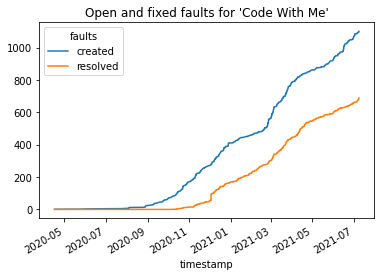

In [16]:
cumulated_faults_over_time.plot(
    title="Open and fixed faults for 'Code With Me'"
);

From this visualization, we can see that the team might be behind regarding fixing bugs. We also see that at the beginning of December 2020, there was a steep increase for bugfixing. It looks like someone clean up the issues tracker right before the official release, doesn't it? :-)

## Conclusion

This post guids us through a variant of *Fault Analysis* using the issues tracker YouTrack. The analysis gives us some hints on how we could approach analyzing our own issue tracker system (or even similiar kinds of data)

We hope you could also see that this kind of analysis isn't magic. Using appropriate standard tools like pandas helps us get answers to our specific questions in a straightforward manner